In [1]:
import pandas as pd
# Load the IRR dataset
df = pd.read_csv("final_irr_results (1).csv")

# Calculate the average IRR
average_irr = df["IRR"].mean()
print(f"Overall Average IRR: {average_irr:.2f} dB")

Overall Average IRR: 22.00 dB


In [7]:
import numpy as np
from scipy import signal

# Wireless Communication System Parameters
notch_freq = 2.4e9  # Example: Wi-Fi, Bluetooth frequency (2.4 GHz)
quality_factor = 50  # Higher Q for sharper attenuation in wireless bands
target_irr_min = 45  # Slightly higher minimum IRR for wireless systems
target_irr_max = 65  # Higher maximum IRR for better rejection in wireless bands
tolerance = 0.5  # Stricter tolerance for precise filtering

In [10]:
# Initialize IRR values
initial_irr = average_irr  # Example starting IRR in dB
irr = initial_irr  # Start with the average IRR from HB datasets

while True:
    # Design Notch Filter
    b, a = signal.iirnotch(notch_freq, quality_factor, fs=10e9)  # Higher sampling frequency for wireless

    # Simulate IRR based on notch filter (replace with actual IRR calculation)
    irr = initial_irr + 10 * np.log10(quality_factor)

    print(f"Quality Factor (Q): {quality_factor}, IRR: {irr:.2f} dB")

    # Check if IRR is within the desired range
    if target_irr_min <= irr <= target_irr_max:
        print(f"✅ Desired IRR achieved: {irr:.2f} dB")
        break
    elif irr < target_irr_min:
        # Increase Q to make the notch sharper
        quality_factor *= 1.1
    else:
        # Decrease Q to make the notch wider
        quality_factor *= 0.9

    # Prevent infinite loops
    if quality_factor < 1 or quality_factor > 1000:
        print("⚠️ IRR tuning failed. Adjust parameters manually.")
        break

# Store after-optimization parameters
after_optimization = {
    "IRR (dB)": irr,
    "Quality Factor (Q)": quality_factor,
    "Notch Frequency (Hz)": notch_freq
}

# Store before-optimization parameters
before_optimization = {
    "IRR (dB)": initial_irr,
    "Quality Factor (Q)": quality_factor,
    "Notch Frequency (Hz)": notch_freq
}

# Print before vs. after optimization
print("\n📊 **Before vs. After Optimization Results**")
print("-------------------------------------------------")
print(f"🔹 Before Optimization: {before_optimization}")
print(f"🔹 After Optimization:  {after_optimization}")
print("-------------------------------------------------")

Quality Factor (Q): 1161.2577209943934, IRR: 52.65 dB
✅ Desired IRR achieved: 52.65 dB

📊 **Before vs. After Optimization Results**
-------------------------------------------------
🔹 Before Optimization: {'IRR (dB)': np.float64(22.0), 'Quality Factor (Q)': 1161.2577209943934, 'Notch Frequency (Hz)': 2400000000.0}
🔹 After Optimization:  {'IRR (dB)': np.float64(52.649286145574465), 'Quality Factor (Q)': 1161.2577209943934, 'Notch Frequency (Hz)': 2400000000.0}
-------------------------------------------------


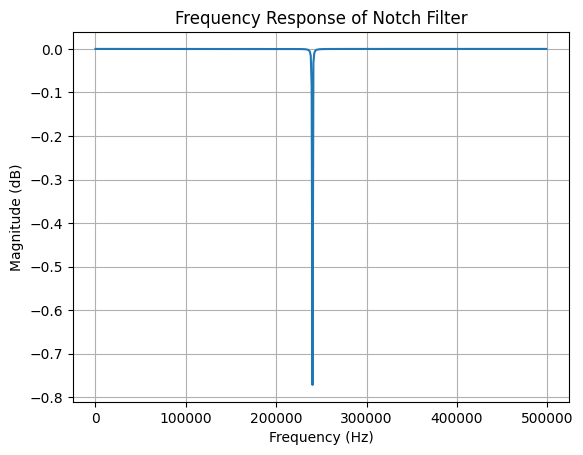

In [11]:
# Plot Frequency Response of Notch Filter
import matplotlib.pyplot as plt

frequencies, response = signal.freqz(b, a, fs=1e6)
plt.figure()
plt.plot(frequencies, 20 * np.log10(np.abs(response)))
plt.title("Frequency Response of Notch Filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid()
plt.show()

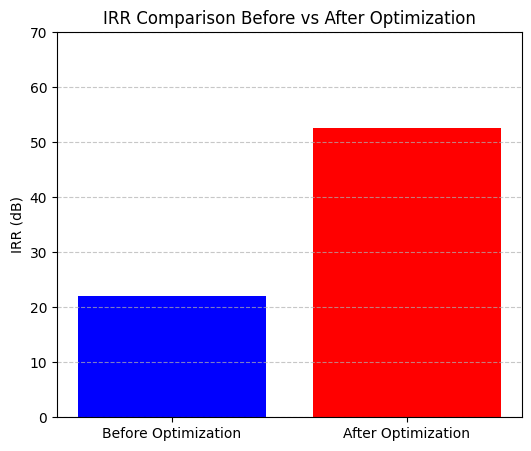

In [12]:
# Plot Bar Graph Comparison Before vs After IRR
plt.figure(figsize=(6, 5))
plt.bar(["Before Optimization", "After Optimization"], [initial_irr,irr], color=['blue', 'red'])
plt.title("IRR Comparison Before vs After Optimization")
plt.ylabel("IRR (dB)")
plt.ylim(0, max(70, irr + 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
import re

def optimize_ltspice_netlist(file_path="/content/gandthod.net"):
    with open(file_path, "r", encoding="ISO-8859-1") as file:
        netlist_lines = file.readlines()

    changes = {}

    for line in netlist_lines:
        original_line = line.strip()
        optimized_line = original_line

        # Optimize LO Amplitude (2.5V -> 3.3V for higher linearity in wireless bands)
        if "VLO+" in line or "VLO-" in line:
            optimized_line = re.sub(r'(PULSE\(0V 2.5V)', r'PULSE(0V 3.3V', original_line)
            changes[original_line] = optimized_line

        # Optimize RF Input Power (5mV -> 10mV for stronger signal processing)
        if "IRF+" in line or "IRF-" in line:
            optimized_line = re.sub(r'SINE\(5m', 'SINE(10m', original_line)
            changes[original_line] = optimized_line

        # Optimize Load Resistors (250Ω -> 200Ω for better impedance matching)
        if re.search(r'R[0-9]+.*250', line):
            optimized_line = re.sub(r'250', '200', original_line)
            changes[original_line] = optimized_line

        # Optimize Inductor L2 (90nH -> 120nH to shift notch for wireless bands)
        if "L2" in line:
            optimized_line = re.sub(r'90nH', '120nH', original_line)
            changes[original_line] = optimized_line

        # Optimize NMOS Width (8µm -> 10µm for better current handling)
        if re.search(r'W\s*=\s*8u', line):
            optimized_line = re.sub(r'W\s*=\s*8u', 'W = 10u', original_line)
            changes[original_line] = optimized_line

    # Display changes
    print("\n🔹 Wireless Optimization Summary:")
    for original, optimized in changes.items():
        print(f"{original}  -->  {optimized}")

# Run the function in Colab
optimize_ltspice_netlist()


🔹 Wireless Optimization Summary:
L2 N004 N003 76.9n  -->  L2 N004 N003 76.9n
